In [1]:
# 搭建VAE模型

In [2]:
import keras
import numpy as np
import time
import datetime
import os
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf


from keras import backend as K
from keras.layers import Dense,Layer,Input,Lambda
from keras.layers import Input, Concatenate, Add
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from sklearn import preprocessing
from sklearn import manifold
from scipy.stats import wasserstein_distance


Using TensorFlow backend.


In [3]:
# # 计算欧氏距离
# def dist(x,y):
#     return np.sqrt(np.sum(np.square(x-y)))


# # 按欧式距离计算精确度
# def calAccuracy_Euc(latent_x,latent_c,class_num = 3):
#     predict_list = []
# #     latent_x = latent_x.tolist()
# #     latent_c = latent_c.tolist()
    
#     if class_num == 3:
#         for i in range(6000): 
#             distance_list = [dist(latent_x[i], latent_c[0]),
#                              dist(latent_x[i], latent_c[1]),
#                              dist(latent_x[i], latent_c[2])]
#             min_index = distance_list.index(min(distance_list))
#             predict_list.append(min_index)
        
# #         print(predict_list)

#         count = 0
#         for i in range(0,2000):
#             if predict_list[i]==0:
#                 count=count+1
#         for i in range(2000,4000):
#             if predict_list[i]==1:
#                 count=count+1
#         for i in range(4000,6000):
#             if predict_list[i]==2:
#                 count=count+1

#         return count
    
#     if class_num == 4:
#         for i in range(8000):
#             distance_list = [dist(latent_x[i], latent_c[0]),
#                              dist(latent_x[i], latent_c[1]),
#                              dist(latent_x[i], latent_c[2]),
#                              dist(latent_x[i], latent_c[3])]
#             min_index = distance_list.index(min(distance_list))
#             predict_list.append(min_index)
        
# #         print(predict_list)

#         count = 0
#         for i in range(0,2000):
#             if predict_list[i]==0:
#                 count=count+1
#         for i in range(2000,4000):
#             if predict_list[i]==1:
#                 count=count+1
#         for i in range(4000,6000):
#             if predict_list[i]==2:
#                 count=count+1
#         for i in range(6000,8000):
#             if predict_list[i]==3:
#                 count=count+1
#         return count


In [4]:
# 计算余弦距离
# def dist(vector_a, vector_b):
#     """
#     计算两个向量之间的余弦相似度
#     :param vector_a: 向量 a 
#     :param vector_b: 向量 b
#     :return: sim
#     """
#     vector_a = np.mat(vector_a)
#     vector_b = np.mat(vector_b)
#     num = float(vector_a * vector_b.T)
#     denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
#     cos = num / denom
#     sim = 0.5 + 0.5 * cos
#     return sim

# 曼哈顿距离
def dist(x,y):
    return np.sum(np.abs(x - y))




# 按欧式距离计算精确度
def calAccuracy_Euc(samples_num,latent_x,latent_c,class_num = 3):
    predict_list = []
#     latent_x = latent_x.tolist()
#     latent_c = latent_c.tolist()
    
    if class_num == 3:
        for i in range(samples_num*3): 
            distance_list = [dist(latent_x[i], latent_c[0]),
                             dist(latent_x[i], latent_c[1]),
                             dist(latent_x[i], latent_c[2])]
            min_index = distance_list.index(min(distance_list))
            predict_list.append(min_index)
        
#         print(predict_list)

        count = 0
        for i in range(0,samples_num):
            if predict_list[i]==0:
                count=count+1
        for i in range(samples_num,samples_num*2):
            if predict_list[i]==1:
                count=count+1
        for i in range(samples_num*2,samples_num*3):
            if predict_list[i]==2:
                count=count+1

        return count
    
    if class_num == 4:
        for i in range(samples_num*4):
            distance_list = [dist(latent_x[i], latent_c[0]),
                             dist(latent_x[i], latent_c[1]),
                             dist(latent_x[i], latent_c[2]),
                             dist(latent_x[i], latent_c[3])]
            min_index = distance_list.index(min(distance_list))
            predict_list.append(min_index)
        
#         print(predict_list)

        count = 0
        for i in range(0,samples_num):
            if predict_list[i]==0:
                count=count+1
        for i in range(samples_num,samples_num*2):
            if predict_list[i]==1:
                count=count+1
        for i in range(samples_num*2,samples_num*3):
            if predict_list[i]==2:
                count=count+1
        for i in range(samples_num*3,samples_num*4):
            if predict_list[i]==3:
                count=count+1
        return count


In [5]:
# 训练集视觉特征
x_train_img = np.load(r".\data\train\x_train_2048.npy")
y_train_oh = np.load(r".\data\train\y_train_oh.npy")
# 测试集视觉特征
x_test_img = np.load(r".\data\test\x_test_2048.npy")
y_test_oh = np.load(r".\data\test\y_test_oh.npy")
# 训练集语义特征
aux_data_train = np.load(r"./data/aux_data/aux_data_train_lsk.npy")
# 测试集语义特征
aux_data_test = np.load(r"./data/aux_data/aux_data_test_lsk.npy")

In [6]:
samples_num = 2000
#处理训练集
x_train_IF = x_train_img[0:samples_num]
x_train_OF = x_train_img[2000:2000+samples_num]
x_train_BF = x_train_img[4000:4000+samples_num]
x_train_img = np.concatenate((x_train_IF,x_train_OF,x_train_BF))
#处理语义
semantic_IF = aux_data_train[0:samples_num]
semantic_OF = aux_data_train[2000:2000+samples_num]
semantic_BF = aux_data_train[4000:4000+samples_num]
aux_data_train = np.concatenate((semantic_IF,semantic_OF,semantic_BF))

In [7]:
print(x_train_img.shape)
print(aux_data_train.shape)

(6000, 2048)
(6000, 256)


In [53]:
# import numpy as np
# IF = [[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]]*2000
# OF = [[0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0]]*2000
# BF = [[0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1]]*2000
# IO = [[1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,0]]*2000
# IB = [[1,1,1,0,0,0,0,1,0,0,0,1,1,0,1,1]]*2000
# OB = [[0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0]]*2000
# IOB =[[1,1,1,1,1,1,0,1,1,0,1,0,0,0,1,1]]*2000

# aux_data_train = IF + OF +BF
# aux_data_test = IO + IB + OB + IOB

# aux_data_train = np.array(aux_data_train)
# print(aux_data_train.shape)

# aux_data_test = np.array(aux_data_test)
# print(aux_data_test.shape)

In [ ]:
# 语义嵌入视觉(autoencoder)
epochs = 2000
s_input = 256
v_input = 2048
hid = 1024


def weight_variable(shape):

    initial = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(initial)


def bias_variable(shape):

    initial = tf.constant(0.05, shape=shape)
    return tf.Variable(initial)




# # Placeholder
# define placeholder for inputs to network
v_features = tf.placeholder(tf.float32, [None, v_input])
s_features = tf.placeholder(tf.float32, [None, s_input])

# # Network
# # encoder
W_left_a1 = weight_variable([v_input, hid])
b_left_a1 = bias_variable([hid])
left_a1 = tf.nn.relu(tf.matmul(v_features, W_left_a1) + b_left_a1) # 2048*(2048,1024)-->1024


W_left_a2 = weight_variable([hid, s_input])
b_left_a2 = bias_variable([s_input])
left_a2 = tf.nn.relu(tf.matmul(left_a1, W_left_a2) + b_left_a2) # 1024*(1024,256)-->256

## decoder
W_left_a3 = weight_variable([s_input, hid])
b_left_a3 = bias_variable([hid])
left_a3_z = tf.nn.relu(tf.matmul(left_a2, W_left_a3) + b_left_a3) # 256*(256,1024)-->1024
left_a3_s = tf.nn.relu(tf.matmul(s_features, W_left_a3) + b_left_a3)  # 256*(256,1024)-->1024

W_left_a4 = weight_variable([hid, v_input])
b_left_a4 = bias_variable([v_input])
left_a4_z = tf.nn.relu(tf.matmul(left_a3_z, W_left_a4) + b_left_a4) # 1024*(1024,2048)-->2048
left_a4_s = tf.nn.relu(tf.matmul(left_a3_s, W_left_a4) + b_left_a4) # 1024*(1024,2048)-->2048

# # loss

# loss_1
loss_1 = tf.losses.huber_loss(s_features,left_a2,delta=1.5)
loss_1 = tf.reduce_sum(loss_1)
# loss_2
loss_2 = tf.losses.absolute_difference(v_features, left_a4_z)
loss_2 = tf.reduce_sum(loss_2)
# loss_3
loss_3 = tf.losses.absolute_difference(v_features, left_a4_s)
loss_3 = tf.reduce_sum(loss_3)
# # loss_2
# loss_2 = tf.losses.mean_squared_error(v_features, left_a4_z)
# loss_2 = tf.reduce_sum(loss_2)
# # loss_3
# loss_3 = tf.losses.mean_squared_error(v_features, left_a4_s)
# loss_3 = tf.reduce_sum(loss_3)


# L2 regularisation for the fully connected parameters.

regularisers_a = (tf.nn.l2_loss(W_left_a1) + tf.nn.l2_loss(b_left_a1)
                  + tf.nn.l2_loss(W_left_a2) + tf.nn.l2_loss(b_left_a2)
                 +tf.nn.l2_loss(W_left_a3) + tf.nn.l2_loss(b_left_a3)
                  + tf.nn.l2_loss(W_left_a4) + tf.nn.l2_loss(b_left_a4))

m=0.1
n=0.3
loss_sum = loss_1+m*loss_2+n*loss_3+1e-3 * regularisers_a

#acc=  accuracy()

train_step = tf.train.AdamOptimizer(0.001).minimize(loss_sum)

sess = tf.Session()

sess.run(tf.global_variables_initializer())
# fig_loss = np.zeros([10])
# fig_acc = np.zeros([10])
#data_fit()

#输出两个列表
list_train = []
list_3 = []
list_4 = []

for epoch in range(epochs):

    s=[]
    # Select a random batch of images
    idx = np.random.randint(0, x_train_img.shape[0], 100)

    v_feature = x_train_img[idx]
    s = aux_data_train[idx]
#     for i in range(len(idx)):

#         if idx[i] <2000:
#             s_attr = aux_data_train[0]
#             s.append(s_attr)
#         if 2000<= idx[i] < 4000:
#             s_attr = aux_data_train[2000]
#             s.append(s_attr)
#         if 4000<= idx[i] < 6000:
#             s_attr = aux_data_train[4000]
#             s.append(s_attr)

#     s_attr = np.atleast_2d(s_attr)

    _, loss_val= sess.run([train_step, loss_sum], feed_dict={v_features: v_feature , s_features: s})
    
    if epoch%50==0:
        print('train loss',loss_val)
        s_train = np.array([aux_data_train[0],aux_data_train[samples_num],aux_data_train[2*samples_num]])
        S_train= sess.run(left_a4_s, feed_dict={s_features: s_train})
        
        s_attr_2 = np.array([aux_data_test[0],aux_data_test[2000],aux_data_test[4000],aux_data_test[6000]])
        S_attr_2= sess.run(left_a4_s, feed_dict={s_features: s_attr_2})
        
        
        
        # 7种语义嵌入子空间
#         s_attr_1 = np.array([aux_data_train[0],aux_data_train[samples_num],aux_data_train[2*samples_num]])
#         S_attr_1= sess.run(left_a4_z, feed_dict={left_a2: s_attr_1})
#         print(S_attr_1.shape)

#         print(S_attr_2.shape)
        count_train = calAccuracy_Euc(samples_num,x_train_img,S_train,class_num = 3)
        count_1 = calAccuracy_Euc(2000,x_test_img,S_attr_2,class_num = 4)
        count_2 = calAccuracy_Euc(2000,x_test_img[0:6000],S_attr_2[0:3],class_num = 3)
        
        list_train.append((100*count_train)/(samples_num*3))
        list_3.append(100*count_2/6000)
        list_4.append(100*count_1/8000)
        print('train accuracy is %0.2f%%'%(100*count_train/(samples_num*3)))
        print('accuracy is %0.2f%%'%(100*count_1/8000))
        print('accuracy is %0.2f%%'%(100*count_2/6000))

   # print('accuracy:',accuracy)
#                 if epoch %1000 == 0:
#                     acc= accuracy()
#                     fig_loss[epoch//1000] = loss_val
#                     fig_acc[epoch//1000] = acc


# print(acc)                





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
train loss 5.2970185
train accuracy is 66.67%
accuracy is 25.00%
accuracy is 33.33%
train loss 1.1756802
train accuracy is 79.98%
accuracy is 35.50%
accuracy is 47.80%
train loss 0.46964008
train accuracy is 86.85%
accuracy is 44.15%
accuracy is 60.38%
train loss 0.29214755
train accuracy is 92.68%
accuracy is 42.96%
accuracy is 59.22%
train loss 0.22190183
train accuracy is 94.58%
accuracy is 49.61%
accuracy is 69.87%
train loss 0.18871261
train accuracy is 95.68%
accuracy is 54.67%
accuracy is 74.63%
train loss 0.1606014
train accuracy is 95.82%
accuracy is 56.14%
accuracy is 76.40%
train loss 0.14145203
train accuracy is 96.57%
accuracy is 56.61%
accuracy is 76.93%
train loss 0.12705415
train accuracy is 97.60%
accuracy is 56.23%
accuracy is 77.43%
train loss 0.12089985
train accuracy is 96.45%
accuracy is 56.74%
accuracy is 77.12%
train loss 0.1157698
train accuracy is 97.10%
accuracy is 5

In [55]:
print(len(list_train))
print(list_3)
print(list_4)

40
[33.333333333333336, 55.21666666666667, 57.25, 59.63333333333333, 65.41666666666667, 72.6, 77.6, 76.6, 77.93333333333334, 74.98333333333333, 74.81666666666666, 75.81666666666666, 76.9, 77.08333333333333, 76.23333333333333, 75.45, 76.38333333333334, 76.48333333333333, 76.76666666666667, 75.91666666666667, 76.7, 77.95, 78.11666666666666, 76.38333333333334, 76.51666666666667, 77.6, 77.35, 74.1, 77.08333333333333, 77.4, 77.21666666666667, 77.81666666666666, 77.05, 76.25, 78.11666666666666, 76.66666666666667, 76.18333333333334, 75.73333333333333, 77.46666666666667, 76.96666666666667]
[25.0, 40.6, 42.0875, 43.4625, 47.275, 52.675, 55.825, 56.0375, 56.5125, 55.1, 54.9, 55.65, 55.8625, 56.35, 55.275, 55.825, 56.3, 55.4375, 55.025, 55.8, 55.5625, 55.525, 56.15, 53.8625, 55.975, 55.8875, 55.9, 55.05, 56.725, 56.375, 56.675, 55.825, 55.9375, 54.9625, 55.175, 55.1875, 55.5125, 56.25, 56.5, 56.025]


In [56]:
tmp = [ 53.8125, 55.8125, 54.3, 56.3875, 55.7875, 56.125, 55.925, 54.9125, 56.575, 56.1, 56.3625, 56.825, 56.45, 55.7, 56.2, 54.9125, 56.6875, 56.075, 56.775, 56.3125, 55.8875, 56.0375, 56.3, 55.7625, 56.425, 56.9125, 56.125, 56.575, 56.5625, 56.3, 56.325, 53.875, 56.55, 56.2375, 57.05, 56.125, 54.4625, 54.9875, 56.5, 56.7375, 55.9125, 55.4125, 56.425, 55.875, 54.025, 56.5125, 57.0, 56.2625]
print(np.mean(tmp))

55.98333333333333


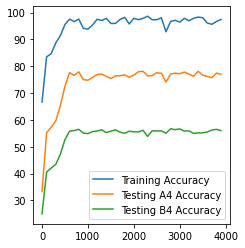

In [57]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt



accs =list_train


val_accs = list_3


val_accs2 = list_4

epochs = len(accs)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([accs], [val_accs], [val_accs2], ['Accuracy'])):
    plt.subplot(1, 3, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[3]))
    plt.plot(range(epochs), metrics[1], label='Testing A4 {}'.format(metrics[3]))
    plt.plot(range(epochs), metrics[2], label='Testing B4 {}'.format(metrics[3]))
    plt.legend()
    
def to_percent(temp, position):
    return '%1.0f'%(100*temp)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent))

# plt.savefig("acc.png")
plt.savefig("FE_Task_A4.png",dpi=700,bbox_inches="tight")
plt.show()



In [ ]:
# 7种语义嵌入子空间
s_attr_1 = np.array([aux_data_train[0],aux_data_train[2000],aux_data_train[4000]])
S_attr_1= sess.run(left_a2, feed_dict={att_features: s_attr_1})
print(S_attr_1.shape)

s_attr_2 = np.array([aux_data_test[0],aux_data_test[2000],aux_data_test[4000],aux_data_test[6000]])
S_attr_2= sess.run(left_a2, feed_dict={att_features: s_attr_2})
print(S_attr_2.shape)

In [ ]:
# 计算训练集精确度
count = calAccuracy_Euc(x_train_img,S_attr_1)
print('accuracy is %0.2f%%'%(100*count/6000)) 

In [ ]:
# 计算测试集精确度-4class
count = calAccuracy_Euc(x_test_img,S_attr_2,class_num = 4)
print('accuracy is %0.2f%%'%(100*count/8000)) 

In [ ]:
# 计算测试集精确度-3class
count = calAccuracy_Euc(x_test_img[0:6000],S_attr_2[0:3],class_num = 3)
print('accuracy is %0.2f%%'%(100*count/6000)) 

In [ ]:
# # 语义嵌入视觉(autoencoder)
# epochs = 10000
# att_input = 1000
# img_input = 2048
# att_hid = 1350


# def weight_variable(shape):

#     initial = tf.truncated_normal(shape, stddev=0.05)
#     return tf.Variable(initial)


# def bias_variable(shape):

#     initial = tf.constant(0.05, shape=shape)
#     return tf.Variable(initial)




# # # Placeholder
# # define placeholder for inputs to network
# att_features = tf.placeholder(tf.float32, [None, att_input])
# #att_features = tf.placeholder(tf.float32, [None, 512])
# visual_features = tf.placeholder(tf.float32, [None, img_input])

# # # Network

# # # encoder
# W_left_a1 = weight_variable([att_input, att_hid])
# #W_left_a1 = weight_variable([512, 1024])
# b_left_a1 = bias_variable([att_hid])
# left_a1 = tf.nn.relu(tf.matmul(att_features, W_left_a1) + b_left_a1)


# W_left_a2 = weight_variable([att_hid, img_input])
# b_left_a2 = bias_variable([img_input])
# left_a2 = tf.nn.relu(tf.matmul(left_a1, W_left_a2) + b_left_a2)

# ## decoder
# W_left_a3 = weight_variable([img_input, att_hid])
# #W_left_a1 = weight_variable([512, 1024])
# b_left_a3 = bias_variable([att_hid])
# left_a3_att = tf.nn.relu(tf.matmul(left_a2, W_left_a3) + b_left_a3)
# left_a3_img = tf.nn.relu(tf.matmul(visual_features, W_left_a3) + b_left_a3)

# W_left_a4 = weight_variable([att_hid, att_input])
# b_left_a4 = bias_variable([att_input])
# left_a4_att = tf.nn.relu(tf.matmul(left_a3_att, W_left_a4) + b_left_a4)
# left_a4_img = tf.nn.relu(tf.matmul(left_a3_img, W_left_a4) + b_left_a4)

# # # loss
# loss_a = tf.losses.huber_loss(visual_features,left_a2)
# # loss_a = wasserstein_loss(visual_features,left_a2 )
# # loss_b = tf.losses.mean_squared_error(att_features, left_a4)
# loss_b = tf.losses.mean_squared_error(att_features, left_a4_att)
# loss_c = tf.losses.mean_squared_error(att_features, left_a4_img)
# # L2 regularisation for the fully connected parameters.

# regularisers_a = (tf.nn.l2_loss(W_left_a1) + tf.nn.l2_loss(b_left_a1)
#                   + tf.nn.l2_loss(W_left_a2) + tf.nn.l2_loss(b_left_a2)
#                  +tf.nn.l2_loss(W_left_a3) + tf.nn.l2_loss(b_left_a3)
#                   + tf.nn.l2_loss(W_left_a4) + tf.nn.l2_loss(b_left_a4))

# k = 0.9
# loss_sum = loss_a+k*loss_b+k*loss_c+1e-3 * regularisers_a



# #acc=  accuracy()

# train_step = tf.train.AdamOptimizer(0.0005).minimize(loss_sum)

# sess = tf.Session()

# sess.run(tf.global_variables_initializer())
# # fig_loss = np.zeros([10])
# # fig_acc = np.zeros([10])
# #data_fit()


# for epoch in range(epochs):

#     s=[]
#     # Select a random batch of images
#     idx = np.random.randint(0, x_train_img.shape[0], 100)

#     v_feature = x_train_img[idx]
#     s = aux_data_train[idx]
# #     for i in range(len(idx)):

# #         if idx[i] <2000:
# #             s_attr = aux_data_train[0]
# #             s.append(s_attr)
# #         if 2000<= idx[i] < 4000:
# #             s_attr = aux_data_train[2000]
# #             s.append(s_attr)
# #         if 4000<= idx[i] < 6000:
# #             s_attr = aux_data_train[4000]
# #             s.append(s_attr)

# #     s_attr = np.atleast_2d(s_attr)

#     _, loss_val= sess.run([train_step, loss_sum], feed_dict={visual_features: v_feature , att_features: s})
    
#     if epoch%100==0:
#         print('train loss',loss_val)
#         # 7种语义嵌入子空间
#         s_attr_1 = np.array([aux_data_train[0],aux_data_train[2000],aux_data_train[4000]])
#         S_attr_1= sess.run(left_a2, feed_dict={att_features: s_attr_1})
# #         print(S_attr_1.shape)
#         s_attr_2 = np.array([aux_data_test[0],aux_data_test[2000],aux_data_test[4000],aux_data_test[6000]])
#         S_attr_2= sess.run(left_a2, feed_dict={att_features: s_attr_2})
# #         print(S_attr_2.shape)
#         count_1 = calAccuracy_Euc(x_test_img,S_attr_2,class_num = 4)
#         count_2 = calAccuracy_Euc(x_test_img[0:6000],S_attr_2[0:3],class_num = 3)
#         print('accuracy is %0.2f%%'%(100*count_1/8000))     
#         print('accuracy is %0.2f%%'%(100*count_2/6000))  

#    # print('accuracy:',accuracy)
# #                 if epoch %1000 == 0:
# #                     acc= accuracy()
# #                     fig_loss[epoch//1000] = loss_val
# #                     fig_acc[epoch//1000] = acc


# # print(acc)                





In [ ]:
# # 语义嵌入视觉(vae)
# epochs = 10000




# def weight_variable(shape):

#     initial = tf.truncated_normal(shape, stddev=0.05)
#     return tf.Variable(initial)



# def bias_variable(shape):

#     initial = tf.constant(0.05, shape=shape)
#     return tf.Variable(initial)




# # # Placeholder
# # define placeholder for inputs to network
# att_features = tf.placeholder(tf.float32, [None, 1000])
# #att_features = tf.placeholder(tf.float32, [None, 512])
# visual_features = tf.placeholder(tf.float32, [None, 2048])

# # # Network

# # # encoder
# W_left_a1 = weight_variable([1000, 1560])
# #W_left_a1 = weight_variable([512, 1024])
# b_left_a1 = bias_variable([1560])
# left_a1 = tf.nn.relu(tf.matmul(att_features, W_left_a1) + b_left_a1)


# W_left_a2_mean = weight_variable([1560, 2048])
# b_left_a2_mean = bias_variable([2048])
# left_a2_mean = tf.nn.relu(tf.matmul(left_a1, W_left_a2_mean) + b_left_a2_mean)

# W_left_a2_var = weight_variable([1560, 2048])
# b_left_a2_var = bias_variable([2048])
# left_a2_var = tf.nn.relu(tf.matmul(left_a1, W_left_a2_var) + b_left_a2_var)

# # 重参数技巧
# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = K.random_normal(shape=K.shape(z_mean))
#     return z_mean + K.exp(z_log_var / 2) * epsilon

# # 重参数层，相当于给输入加入噪声
# z = Lambda(sampling, output_shape=(2048,))([left_a2_mean, left_a2_var])

# ## decoder
# W_left_a3 = weight_variable([2048, 1560])
# #W_left_a1 = weight_variable([512, 1024])
# b_left_a3 = bias_variable([1560])
# left_a3 = tf.nn.relu(tf.matmul(z, W_left_a3) + b_left_a3)


# W_left_a4 = weight_variable([1560, 1000])
# b_left_a4 = bias_variable([1000])
# left_a4 = tf.nn.relu(tf.matmul(left_a3, W_left_a4) + b_left_a4)

# # # # loss

# loss_a = tf.losses.mean_squared_error(z, visual_features) 
# loss_b = tf.losses.mean_squared_error(att_features, left_a4)

# # marginal_likelihood loss为y与输入数据x之间交叉墒，即解码器的损失
# # marginal_likelihood = tf.reduce_sum(att_features * tf.log(left_a4) + (1 - att_features) * tf.log(1 - left_a4), 1)
# # marginal_likelihood = tf.losses.mean_squared_error(att_features, left_a4)

# # # KL_divergence为z与标准高斯分布之间的差距，即编码器的损失
# # KL_divergence = 0.5 * tf.reduce_sum(tf.square(left_a2_mean) + tf.square(left_a2_var) - tf.log(1e-8 + tf.square(left_a2_var)) - 1, 1)
# # KL_divergence = tf.reduce_mean(KL_divergence)

# # # 变分下界L(x)，目标最大化
# # ELBO = marginal_likelihood - KL_divergence

# # # 令损失函数为-L(x)，目标梯度下降最小化
# # loss_b = -ELBO

# # L2 regularisation for the fully connected parameters.

# regularisers_a = (tf.nn.l2_loss(W_left_a1) + tf.nn.l2_loss(b_left_a1)+ tf.nn.l2_loss(W_left_a2_mean) + tf.nn.l2_loss(b_left_a2_var)
#                   +tf.nn.l2_loss(W_left_a2_var) + tf.nn.l2_loss(b_left_a2_var)
#                  +tf.nn.l2_loss(W_left_a3) + tf.nn.l2_loss(b_left_a3)+ tf.nn.l2_loss(W_left_a4) + tf.nn.l2_loss(b_left_a4))


# # loss_a = loss_a+0.5*loss_b+1e-3 * regularisers_a
# loss_sum = loss_a+0.5*loss_b+1e-3 * regularisers_a



# #acc=  accuracy()

# train_step = tf.train.AdamOptimizer(0.001).minimize(loss_sum)

# sess = tf.Session()

# sess.run(tf.global_variables_initializer())
# fig_loss = np.zeros([10])
# fig_acc = np.zeros([10])
# #data_fit()


# for epoch in range(epochs):

#     s=[]
#     # Select a random batch of images
#     idx = np.random.randint(0, x_train_img.shape[0], 100)

#     v_feature = x_train_img[idx]
#     s = aux_data_train[idx]
# #     for i in range(len(idx)):

# #         if idx[i] <2000:
# #             s_attr = aux_data_train[0]
# #             s.append(s_attr)
# #         if 2000<= idx[i] < 4000:
# #             s_attr = aux_data_train[2000]
# #             s.append(s_attr)
# #         if 4000<= idx[i] < 6000:
# #             s_attr = aux_data_train[4000]
# #             s.append(s_attr)

# #     s_attr = np.atleast_2d(s_attr)

#     _, loss_val= sess.run([train_step, loss_a], feed_dict={visual_features: v_feature , att_features: s})
    
#     if epoch%100==0:
#         print('train loss',loss_val)

#    # print('accuracy:',accuracy)
# #                 if epoch %1000 == 0:
# #                     acc= accuracy()
# #                     fig_loss[epoch//1000] = loss_val
# #                     fig_acc[epoch//1000] = acc


# # print(acc)                





In [ ]:
# # 设置超参数
# batch_size = 100
# original_dim_img = 2048
# original_dim_att = 1000
# latent_dim = 2048 # 隐变量取2维只是为了方便后面画图
# intermediate_dim = 1560
# epochs = 50

In [ ]:
# x_img = Input(shape=(original_dim_img,))
# x_att = Input(shape=(original_dim_att,))
# h_att = Dense(intermediate_dim, activation='relu')(x_att)

# # 算p(Z|X)的均值和方差
# z_mean = Dense(latent_dim)(h_att)
# z_log_var = Dense(latent_dim)(h_att)

# # 重参数技巧
# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = K.random_normal(shape=K.shape(z_mean))
#     return z_mean + K.exp(z_log_var / 2) * epsilon

# # 重参数层，相当于给输入加入噪声
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# # 解码层，也就是生成器部分
# decoder_h = Dense(intermediate_dim, activation='relu')
# decoder_mean = Dense(original_dim_att, activation='sigmoid')
# h_decoded = decoder_h(z)
# x_decoded_mean = decoder_mean(h_decoded)

# # 建立模型
# model = Model([x_img,x_att], x_decoded_mean)

# # xent_loss是重构loss，kl_loss是KL loss
# xent_loss = K.sum(K.binary_crossentropy(x_att, x_decoded_mean), axis=-1)
# kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
# vae_loss = K.mean(xent_loss + kl_loss)

# # 对齐loss
# align_loss = 0.5*tf.losses.mean_squared_error(z, x_img) 

# # loss_sum = vae_loss + 0.5*align_loss

# # add_loss是新增的方法，用于更灵活地添加各种loss
# loss_sum = model.add_loss(vae_loss)
# loss_sum = model.add_loss(align_loss)

# opt = keras.optimizers.adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
# model.compile(optimizer=opt,metrics=[vae_loss, align_loss])
# model.summary()

# model.fit([x_train_img,aux_data_train],
#         shuffle=True,
#         epochs=epochs,
#         batch_size=batch_size,
#         )

In [ ]:
# # 7种语义嵌入子空间
# s_attr_1 = np.array([aux_data_train[0],aux_data_train[2000],aux_data_train[4000]])
# #取某一层的输出为输出新建为model，采用函数模型
# z_layer_model = Model(inputs=x_att,outputs=model.get_layer('lambda_11').output)
# #以这个model的预测值作为输出
# S_attr_1 = z_layer_model.predict(s_attr_1)
# print(S_attr_1.shape)

# s_attr_2 = np.array([aux_data_test[0],aux_data_test[2000],aux_data_test[4000],aux_data_test[6000]])
# #取某一层的输出为输出新建为model，采用函数模型
# # z_layer_model = Model(inputs=model.input,outputs=model.get_layer('lambda_2').output)
# #以这个model的预测值作为输出
# S_attr_2 = z_layer_model.predict(s_attr_2)
# print(S_attr_2.shape)

# # 计算欧氏距离
# def dist(x,y):
#     return np.sqrt(np.sum(np.square(x-y)))

# # 按欧式距离计算精确度
# def calAccuracy_Euc(latent_x,latent_c,class_num = 3):
#     predict_list = []
# #     latent_x = latent_x.tolist()
# #     latent_c = latent_c.tolist()
    
#     if class_num == 3:
#         for i in range(6000): 
#             distance_list = [dist(latent_x[i], latent_c[0]),
#                              dist(latent_x[i], latent_c[1]),
#                              dist(latent_x[i], latent_c[2])]
#             min_index = distance_list.index(min(distance_list))
#             predict_list.append(min_index)
        
#         print(predict_list)

#         count = 0
#         for i in range(0,2000):
#             if predict_list[i]==0:
#                 count=count+1
#         for i in range(2000,4000):
#             if predict_list[i]==1:
#                 count=count+1
#         for i in range(4000,6000):
#             if predict_list[i]==2:
#                 count=count+1

#         return count
    
#     if class_num == 4:
#         for i in range(8000):
#             distance_list = [dist(latent_x[i], latent_c[0]),
#                              dist(latent_x[i], latent_c[1]),
#                              dist(latent_x[i], latent_c[2]),
#                              dist(latent_x[i], latent_c[3])]
#             min_index = distance_list.index(min(distance_list))
#             predict_list.append(min_index)
        
#         print(predict_list)

#         count = 0
#         for i in range(0,2000):
#             if predict_list[i]==0:
#                 count=count+1
#         for i in range(2000,4000):
#             if predict_list[i]==1:
#                 count=count+1
#         for i in range(4000,6000):
#             if predict_list[i]==2:
#                 count=count+1
#         for i in range(6000,8000):
#             if predict_list[i]==3:
#                 count=count+1
#         return count

        
    

In [ ]:
# # 语义嵌入视觉
# epochs = 10000




# def weight_variable(shape):

#     initial = tf.truncated_normal(shape, stddev=0.05)
#     return tf.Variable(initial)



# def bias_variable(shape):

#     initial = tf.constant(0.05, shape=shape)
#     return tf.Variable(initial)




# # # Placeholder
# # define placeholder for inputs to network
# att_features = tf.placeholder(tf.float32, [None, 1000])
# #att_features = tf.placeholder(tf.float32, [None, 512])
# visual_features = tf.placeholder(tf.float32, [None, 2048])

# # # Network


# W_left_a1 = weight_variable([1000, 1024])
# #W_left_a1 = weight_variable([512, 1024])
# b_left_a1 = bias_variable([1024])
# left_a1 = tf.nn.relu(tf.matmul(att_features, W_left_a1) + b_left_a1)


# W_left_a2 = weight_variable([1024, 2048])
# b_left_a2 = bias_variable([2048])
# left_a2 = tf.nn.relu(tf.matmul(left_a1, W_left_a2) + b_left_a2)

# # # loss

# loss_a = tf.reduce_mean(tf.square(left_a2 - visual_features))    

# # L2 regularisation for the fully connected parameters.

# regularisers_a = (tf.nn.l2_loss(W_left_a1) + tf.nn.l2_loss(b_left_a1)
#                     + tf.nn.l2_loss(W_left_a2) + tf.nn.l2_loss(b_left_a2))


# loss_a += 1e-3 * regularisers_a



# #acc=  accuracy()

# train_step = tf.train.AdamOptimizer(0.0001).minimize(loss_a)

# sess = tf.Session()

# sess.run(tf.global_variables_initializer())
# fig_loss = np.zeros([10])
# fig_acc = np.zeros([10])
# #data_fit()


# for epoch in range(epochs):

#     s=[]
#     # Select a random batch of images
#     idx = np.random.randint(0, x_train_img.shape[0], 100)

#     v_feature = x_train_img[idx]
#     s = aux_data_train[idx]
# #     for i in range(len(idx)):

# #         if idx[i] <2000:
# #             s_attr = aux_data_train[0]
# #             s.append(s_attr)
# #         if 2000<= idx[i] < 4000:
# #             s_attr = aux_data_train[2000]
# #             s.append(s_attr)
# #         if 4000<= idx[i] < 6000:
# #             s_attr = aux_data_train[4000]
# #             s.append(s_attr)

# #     s_attr = np.atleast_2d(s_attr)

#     _, loss_val= sess.run([train_step, loss_a], feed_dict={visual_features: v_feature , att_features: s})
    
#     if epoch%100==0:
#         print('train loss',loss_val)

#    # print('accuracy:',accuracy)
# #                 if epoch %1000 == 0:
# #                     acc= accuracy()
# #                     fig_loss[epoch//1000] = loss_val
# #                     fig_acc[epoch//1000] = acc


# # print(acc)                





In [ ]:
# # 语义与视觉嵌入公共子空间
# epochs = 10000




# def weight_variable(shape):

#     initial = tf.truncated_normal(shape, stddev=0.05)
#     return tf.Variable(initial)



# def bias_variable(shape):

#     initial = tf.constant(0.05, shape=shape)
#     return tf.Variable(initial)




# # # Placeholder
# # define placeholder for inputs to network
# att_features = tf.placeholder(tf.float32, [None, 1000])
# #att_features = tf.placeholder(tf.float32, [None, 512])
# visual_features = tf.placeholder(tf.float32, [None, 512])

# # # Network


# W_left_a1 = weight_variable([1000, 1024])
# #W_left_a1 = weight_variable([512, 1024])
# b_left_a1 = bias_variable([1024])
# left_a1 = tf.nn.relu(tf.matmul(att_features, W_left_a1) + b_left_a1)


# W_left_a2 = weight_variable([1024, 2048])
# b_left_a2 = bias_variable([2048])
# left_a2 = tf.nn.relu(tf.matmul(left_a1, W_left_a2) + b_left_a2)

# W_left_b1 = weight_variable([512, 1024])
# #W_left_a1 = weight_variable([512, 1024])
# b_left_b1 = bias_variable([1024])
# left_b1 = tf.nn.relu(tf.matmul(visual_features, W_left_b1) + b_left_b1)


# W_left_b2 = weight_variable([1024, 2048])
# b_left_b2 = bias_variable([2048])
# left_b2 = tf.nn.relu(tf.matmul(left_b1, W_left_b2) + b_left_b2)



# # # loss

# loss_a = tf.reduce_mean(tf.square(left_a2 - left_b2))    

# # L2 regularisation for the fully connected parameters.

# regularisers_a = (tf.nn.l2_loss(W_left_a1) + tf.nn.l2_loss(b_left_a1)+ tf.nn.l2_loss(W_left_a2) + tf.nn.l2_loss(b_left_a2)
#                  +tf.nn.l2_loss(W_left_b1) + tf.nn.l2_loss(b_left_b1)+ tf.nn.l2_loss(W_left_b2) + tf.nn.l2_loss(b_left_b2))


# loss_a += 1e-3 * regularisers_a



# #acc=  accuracy()

# train_step = tf.train.AdamOptimizer(0.0001).minimize(loss_a)

# sess = tf.Session()

# sess.run(tf.global_variables_initializer())
# fig_loss = np.zeros([10])
# fig_acc = np.zeros([10])
# #data_fit()


# for epoch in range(epochs):

#     s=[]
#     # Select a random batch of images
#     idx = np.random.randint(0, x_train_img.shape[0], 100)

#     v_feature = x_train_img[idx]
#     s = aux_data_train[idx]
# #     for i in range(len(idx)):

# #         if idx[i] <2000:
# #             s_attr = aux_data_train[0]
# #             s.append(s_attr)
# #         if 2000<= idx[i] < 4000:
# #             s_attr = aux_data_train[2000]
# #             s.append(s_attr)
# #         if 4000<= idx[i] < 6000:
# #             s_attr = aux_data_train[4000]
# #             s.append(s_attr)

# #     s_attr = np.atleast_2d(s_attr)

#     _, loss_val= sess.run([train_step, loss_a], feed_dict={visual_features: v_feature , att_features: s})
    
#     if epoch%100==0:
#         print('train loss',loss_val)

#    # print('accuracy:',accuracy)
# #                 if epoch %1000 == 0:
# #                     acc= accuracy()
# #                     fig_loss[epoch//1000] = loss_val
# #                     fig_acc[epoch//1000] = acc


# # print(acc)                





In [ ]:
# # 按余弦相似度分类
# def cosine_classify(_latent_visual,_latent_semantic):
#     predict_list = []
#     latent_visual = _latent_visual.tolist()
#     latent_semantic = _latent_semantic.tolist()
#     if _latent_semantic.shape[0] == 3:
#         for i in range(len(latent_visual)):
#             cosine_list = [cosine_similarity(latent_visual[i], latent_semantic[0]),
#                            cosine_similarity(latent_visual[i], latent_semantic[1]),
#                            cosine_similarity(latent_visual[i], latent_semantic[2]),
#     #                        cosine_similarity(latent_visual[i], latent_semantic[3])
#                           ]
#             max_index = cosine_list.index(max(cosine_list))
#             predict_list.append(max_index)
#     else:
#         for i in range(len(latent_visual)):
#             cosine_list = [cosine_similarity(latent_visual[i], latent_semantic[0]),
#                            cosine_similarity(latent_visual[i], latent_semantic[1]),
#                            cosine_similarity(latent_visual[i], latent_semantic[2]),
#                            cosine_similarity(latent_visual[i], latent_semantic[3])
#                           ]
#             max_index = cosine_list.index(max(cosine_list))
#             predict_list.append(max_index)
            
#     return predict_list

In [ ]:
# # 计算精确度
# def calAccuracy(latent_x,latent_c):
    
#     predict_list = cosine_classify(latent_x,latent_c)
    
#     print(predict_list)

#     count = 0
#     for i in range(0,2000):
#         if predict_list[i]==0:
#             count=count+1
#     for i in range(2000,4000):
#         if predict_list[i]==1:
#             count=count+1
#     for i in range(4000,6000):
#         if predict_list[i]==2:
#             count=count+1
#     if len(predict_list)>6000:
#         for i in range(6000,8000):
#             if predict_list[i]==3:
#                 count=count+1
            

#     return count
    

In [ ]:
# # 计算欧氏距离
# def calEuclideanDistance(vec1,vec2):  
#     dist = np.sqrt(np.sum(np.square(vec1 - vec2)))  
#     return dist  

In [ ]:
# # 视觉向量嵌入子空间
# V_img_1= sess.run(left_b2, feed_dict={visual_features: x_train_img})
# print(V_img_1.shape)


# V_img_2= sess.run(left_b2, feed_dict={visual_features: x_test_img})
# print(V_img_2.shape)